INSTALLATION

In [1]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Library

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

Visualize Data using Scatterplot and Heatmap

In [18]:
breast_cancer = datasets.load_breast_cancer()
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['target'] = breast_cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


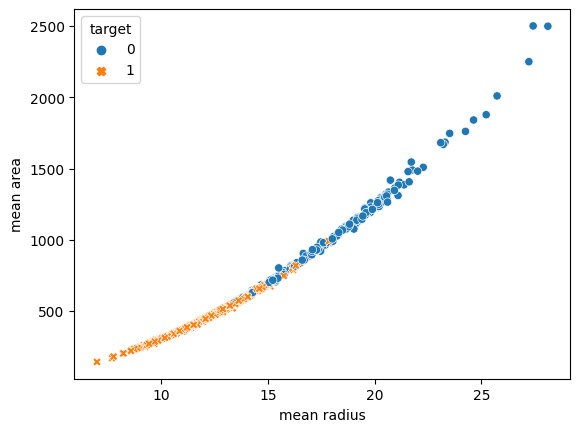

In [19]:

sns.scatterplot(data=df,
               x="mean radius",
               y="mean area",
                hue="target",
               style="target")
plt.show()
plt.show()

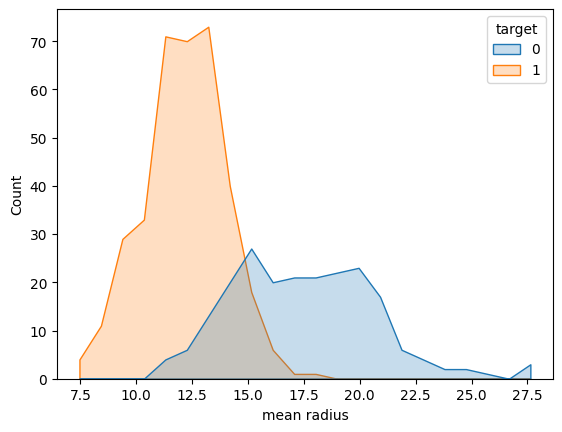

In [25]:
sns.histplot(data=df,
            x="mean radius",
            hue="target",
            element="poly")
plt.show()

Decision Tree

In [29]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
     

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

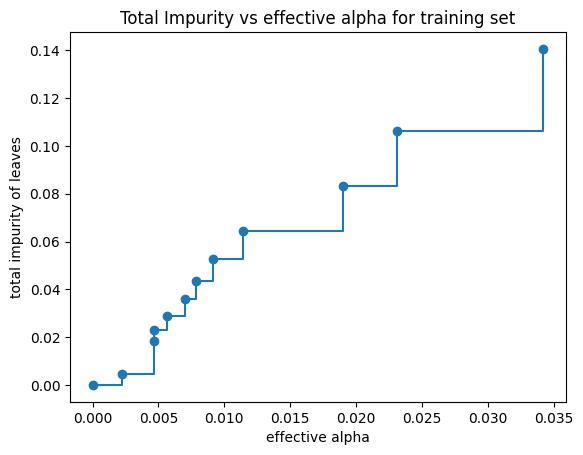

In [30]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Random Forest

In [31]:
random_forest = RandomForestClassifier(n_estimators= 100, random_state=0)
random_forest.fit(X = X_train, y = y_train)

y_pred = random_forest.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        53
           1       0.99      0.97      0.98        90

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



self training

Self Training


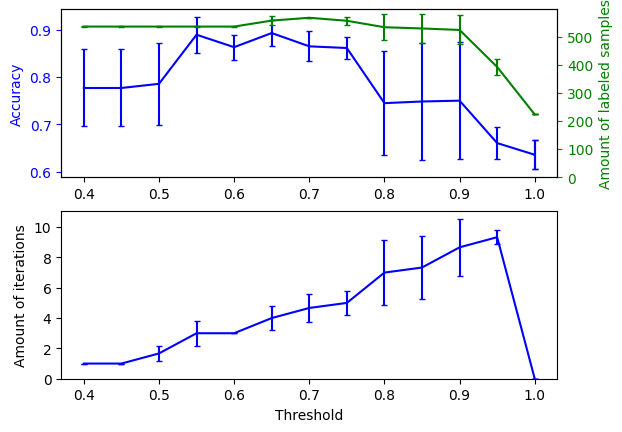

In [32]:
n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")
print("Self Training")
plt.show()